# Baseline analysis (ECMWF hindcasts (2000-2019))

In [1]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import numpy as np

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
hindcast_observation = xr.open_zarr('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\hindcast-like-observations_2000-2019_biweekly_deterministic.zarr')
hindcast_ecmwf = xr.open_zarr('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr')
tercile_edges = xr.open_dataset('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc')

hindcast_observationter = xr.open_zarr('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\hindcast-like-observations_2000-2019_biweekly_terciled.zarr')

In [4]:
from scripts import add_year_week_coords
from scripts import  make_probabilistic

In [5]:
hindcast_observprob = make_probabilistic(hindcast_observation, tercile_edges = tercile_edges)

In [5]:
hindcast_observation.lead_time.diff('lead_time')

<xarray.DataArray 'lead_time' (lead_time: 1)>
array([1209600000000000], dtype='timedelta64[ns]')
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 28 days

## ROC curve 

ROC curves are a way to compare a set of continuous-valued scores to a set of binary-valued labels by applying a varying discrimination threshold to the scores.

If your scores are already binary then there's no need to apply any threshold - just compute the true-positive rate and false-positive rate by directly comparing your scores to your labels, e.g.:

tpr = np.mean((y_score == 1) & (y_label == 1)),

fpr = np.mean((y_score == 1) & (y_label == 0))

If you try to plot the ROC curve for a set of binary scores, you end up with a line containing only three points because there are only three possible pairs of TPR/FPR values:

    If threshold > 1 then you classify every sample as negative, and therefore both your FPR and TPR are both 0.
    If threshold <= 0 then you classify every sample as positive, and therefore your TPR is equal to the fraction of 1s in your set of labels, and your FPR is equal to the fraction of 0s in your labels.
    If 0 < threshold <= 1 then your TPR and FPR values are equivalent to the standard TPR and FPR values calculated above.

In [9]:
def ROC(dataset, probabilistic, tercile_edges, longitude, latitude, variable, lead_time, start, end):
    aprob = probabilistic[variable].sel(forecast_time= slice(start, end)).isel(lead_time = lead_time).sel(longitude = longitude, latitude = latitude, method = 'nearest').isel(category = 2).values
    nnprob = probabilistic[variable].sel(forecast_time= slice(start, end)).isel(lead_time = lead_time).sel(longitude = longitude, latitude = latitude, method = 'nearest').isel(category = 1).values
    bprob = probabilistic[variable].sel(forecast_time= slice(start, end)).isel(lead_time = lead_time).sel(longitude = longitude, latitude = latitude, method = 'nearest').isel(category = 0).values
    
    x_plus = dataset[variable].sel(forecast_time= slice(start, end)).isel(lead_time = lead_time).sel(longitude = longitude, latitude = latitude, method = 'nearest')

    upper = []
    lower = []
    for i in range(0,len(dataset.forecast_time)):
        if i < 53:
            u = tercile_edges[variable].isel(week = i, category_edge = 1, lead_time = lead_time).sel(longitude = longitude, latitude = latitude, method = 'nearest').values
            upper.append(u)
            l = tercile_edges[variable].isel(week = i, category_edge = 0, lead_time = lead_time).sel(longitude = longitude, latitude = latitude, method = 'nearest').values
            lower.append(l)

    for i in range(0,(int(len(dataset.forecast_time)/53)-1)):
        for j in range(0, 53):
            upper.append(upper[j])
            lower.append(lower[j])
            
    dataset['upper']=(['forecast_time'], upper)
    dataset['lower']=(['forecast_time'], lower)

    u = dataset.upper.sel(forecast_time= slice(start, end))

    l = dataset.lower.sel(forecast_time= slice(start, end))

    
    forecast_time = x_plus.forecast_time
    
    above = []
    nnormal = []
    below = []
    
    
    for i in range(0, len(forecast_time)):
        
        if x_plus.isel(forecast_time = i).values > u.isel(forecast_time = i):
            a = 1
            above.append(a)
        else:
            a = 0
            above.append(a)
            
        if l.isel(forecast_time = i) < x_plus.isel(forecast_time =  i) < u.isel(forecast_time = i):
            nn = 1
            nnormal.append(nn)
        else:
            nn = 0
            nnormal.append(nn)
        
        if x_plus.isel(forecast_time = i) < l.isel(forecast_time = i):

            b = 1
            below.append(b)
        else:
            b = 0
            below.append(b)
    
    
    ns_probs = [0 for _ in range(len(aprob))]
    # calculate scores
    ns_auc = roc_auc_score(above, ns_probs)
    nma_auc = roc_auc_score(above, aprob)
    nmnn_auc = roc_auc_score(nnormal, nnprob)
    nmb_auc = roc_auc_score(below, bprob)
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(above, ns_probs)
    nma_fpr, nma_tpr, _ = roc_curve(above, aprob)
    nmnn_fpr, nmnn_tpr, _ = roc_curve(nnormal, nnprob)
    nmb_fpr, nmb_tpr, _ = roc_curve(below, bprob)
    
    # plot the ROC
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    axes.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    axes.plot(nma_fpr, nma_tpr, color = 'r', label = 'Above normal, AUC = {:.3f}'.format(nma_auc))
    axes.plot(nmnn_fpr, nmnn_tpr, color = 'g', label = 'Near normal, AUC = {:.3f}'.format(nmnn_auc))
    axes.plot(nmb_fpr, nmb_tpr, color = 'y', label = 'Below normal, AUC = {:.3f}'.format(nmb_auc))
    axes.set_ylim(ymin = 0)
    axes.set_xlim(xmin = 0)
    axes.set(xlabel= 'False Positive Rate', ylabel='True Positive Rate', title = 'Receiver operating characteristic curve (ROC)')
    axes.legend(loc="upper left")
    
    return aprob, nnprob, bprob, above, nnormal, below

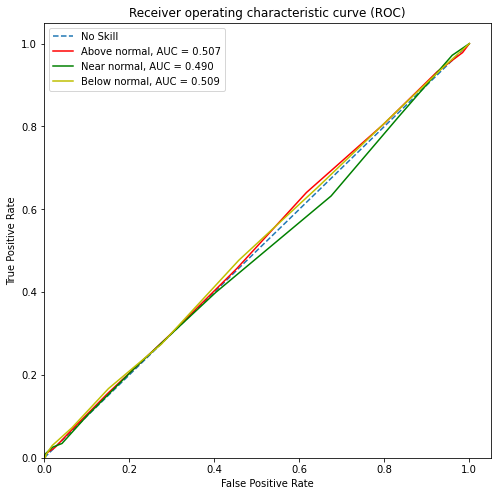

In [15]:
# region1 = ROC(hindcast_observation , hindcast_ecmwfter, tercile_edges, 100, 36, 'tp', 1, '2000-01-01', '2019-12-30')
# region2 = ROC(hindcast_observation , hindcast_ecmwfter, tercile_edges, 100, 55, 'tp', 1, '2000-01-01', '2019-12-30')
region3 = ROC(hindcast_observation , hindcast_ecmwfter, tercile_edges, 6, 53, 'tp', 1, '2000-01-01', '2019-12-30')

## ECMWF hindcasts evaluation using RPSS

In [21]:
import xskillscore as xs

In [22]:
hindcast_ecmwfter = make_probabilistic(hindcast_ecmwf, tercile_edges = tercile_edges)

In [23]:
clim_p = xr.DataArray([1/3, 1/3, 1/3], dims='category', coords={'category':['below normal', 'near normal', 'above normal']}).to_dataset(name='tp')
clim_p['t2m'] = clim_p['tp']

In [24]:
obs_p = hindcast_observprob['tp'].isel(lead_time = 0)
ecmwf_p = hindcast_ecmwfter['tp'].isel(lead_time = 0)

In [33]:
rps_ecmwf = xs.rps(obs_p, ecmwf_p, category_edges=None, dim=[], input_distributions='p').compute()

In [34]:
rps_CL = xs.rps(obs_p, clim_p['tp'], category_edges=None, dim=[], input_distributions='p').compute()

### RPSS with respect to climatology

In [41]:
rpss = 1 - (rps_ecmwf.mean('forecast_time') / rps_CL.mean('forecast_time'))

In [43]:
# region1 = rpss.sel(longitude = slice(95, 100)).sel(latitude = slice(36, 31))
# region1.mean('latitude').mean('longitude').values
# region2 = rpss.sel(longitude = slice(100, 105)).sel(latitude = slice(60, 55))
# region2.mean('latitude').mean('longitude').values
region3 = rpss.sel(longitude = slice(5, 10)).sel(latitude = slice(53, 48))
region3.mean('latitude').mean('longitude').values

array(-0.16543473)